See the writeup: [Partisanship, Nerd-love, and Race](https://medium.com/@generativist/partisanship-nerd-love-and-race-2aed018f4a16)

In [2]:
from __future__ import division
from __future__ import print_function


import json
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import sys
import pandas as pd

from IPython.display import HTML


%matplotlib inline

Code and Data
===

I collected the follower id data via the [Twitter API](https://dev.twitter.com/overview/documentation) on 2016-03-06. However, Twitter really doesn't like it when you share their data (just ask [SNAP](https://snap.stanford.edu/data/twitter7.html)). Since I've been building a lot of Twitter stuff lately, I'd like to stay on its good side. But, in the name of replication, I wanted to share everything necessary to run this study. Consequently, I anonymized the IDs. Basically, the relationships are intact, but -- for most of them -- you can't infer identity without downloading a lot of public data from the API.

I can't imagine Twitter balking at this, but...

In [3]:
DATA_DIR = os.path.join(os.curdir, "data")
FOLLOWER_IDS_DIR = os.path.join(DATA_DIR, "follower_ids")
df = pd.read_csv(os.path.join(DATA_DIR, "screen_names.csv"))


SCIENTISTS = ["billnye", "neiltyson"]
PROMINENT_BLM = ["deray", "aliciagarza", "osope", "opalayo", 
                 "shaunking", "rissaoftheway", "nettaaaaaaaa",
                 "nvlevy"]
POLITICIANS = list(df['Screen_Name'])
SCREEN_NAMES_BY_PARTY = df.groupby(df['Party'])['Screen_Name'].apply(set).to_dict()
LEADERS = set(df['Screen_Name'][df['Is_Leader']])


def build_followers():
    followers = {}
    for screen_name in SCIENTISTS + POLITICIANS + PROMINENT_BLM:
        file_path = os.path.join(FOLLOWER_IDS_DIR, screen_name + ".ids.json")
        with open(file_path) as fp:
            followers[screen_name] = set(json.load(fp))
    return followers


FOLLOWERS = build_followers()


def p_h_given_x(h, x):
    return len(h & x) / len(x)


def build_party_followers():
    party_followers = {'R': set(), 'D': set()}
    for party, screen_names in SCREEN_NAMES_BY_PARTY.items():
        for screen_name in screen_names:
            party_followers[party].update(FOLLOWERS[screen_name])
    return party_followers


PARTY_FOLLOWERS = build_party_followers()

PARTY_OPPOSITE = {'R': 'D', 'D': 'R'}
        
PARTISON_FOLLOWERS = {a: PARTY_FOLLOWERS[a] - PARTY_FOLLOWERS[b]
                      for a, b in PARTY_OPPOSITE.items()}


def all_followers_except(screen_names, exception):
    return reduce(lambda s, k: s | FOLLOWERS[k],
                  (n for n in screen_names if n != exception),
                  set())

def build_singular_followers():
    singular_followers = {}
    for party, screen_names in SCREEN_NAMES_BY_PARTY.items():
        for k in screen_names:
            x = FOLLOWERS[k] - all_followers_except(screen_names, k)
            singular_followers[k] = x - PARTISON_FOLLOWERS[PARTY_OPPOSITE[party]]
    return singular_followers


SINGULAR_FOLLOWERS = build_singular_followers()

FOLLOWS_BOTH_SCI = FOLLOWERS["billnye"] & FOLLOWERS["neiltyson"]
FOLLOWS_EITHER_SCI = FOLLOWERS["billnye"] | FOLLOWERS["neiltyson"]
FOLLOWS_BLM = reduce(lambda s, k: s | FOLLOWERS[k], PROMINENT_BLM, set())

SCIENTIST_COLORS = ["#7fc97f", "#beaed4"]
POLITICAL_COLORS = ["#377eb8", "#e41a1c"]


def compute_conditionals(followers_sets, ignoring=set()):
    cond_p = {}
    
    for scientist in SCIENTISTS:
        cond_p[scientist] = {}

        for party in SCREEN_NAMES_BY_PARTY.keys():
            h = FOLLOWERS[scientist] - ignoring
            x = followers_sets[party] - ignoring
            
            cond_p[scientist][party] = p_h_given_x(h, x)
    
    return pd.DataFrame(cond_p)


def ratio_of_proportions_ci(p_1, p_2, n, sample_k):
    sample_1 = stats.binom(n, p_1).rvs(sample_k) / n
    sample_2 = stats.binom(n, p_2).rvs(sample_k) / n
    theta = sample_1 / sample_2
    
    infinities = sample_2 == 0.0
    if infinities.sum() > 0:
        print("Removing {} infinities!".format(infinities.sum()))
        theta = theta[~infinities]
        
    return np.percentile(theta, [2.5, 97.5])

del df

# Analysis

## Scientist Priors

In [4]:
NYE_TO_TYSON = len(FOLLOWERS["billnye"]) / len(FOLLOWERS["neiltyson"])
print("Nye has {:2.2f}% the followers of Tyson".format(NYE_TO_TYSON*100))

Nye has 55.63% the followers of Tyson


In [6]:
len(FOLLOWERS["billnye"]), len(FOLLOWERS["neiltyson"])

(2792634, 5019717)

In [5]:
NYE_TO_TYSON_NONSHARED = (len(FOLLOWERS["billnye"] - FOLLOWS_BOTH_SCI) / 
                          len(FOLLOWERS["neiltyson"] - FOLLOWS_BOTH_SCI))
fmt = "Nye has {:2.2f}% the nonshared followers of Tyson"
print(fmt.format(NYE_TO_TYSON_NONSHARED*100))

Nye has 34.10% the nonshared followers of Tyson


In [7]:
(len(FOLLOWERS["billnye"] - FOLLOWS_BOTH_SCI), 
 len(FOLLOWERS["neiltyson"] - FOLLOWS_BOTH_SCI))

(1152501, 3379584)

In [8]:
len(FOLLOWERS["billnye"] & FOLLOWERS["neiltyson"])

1640133

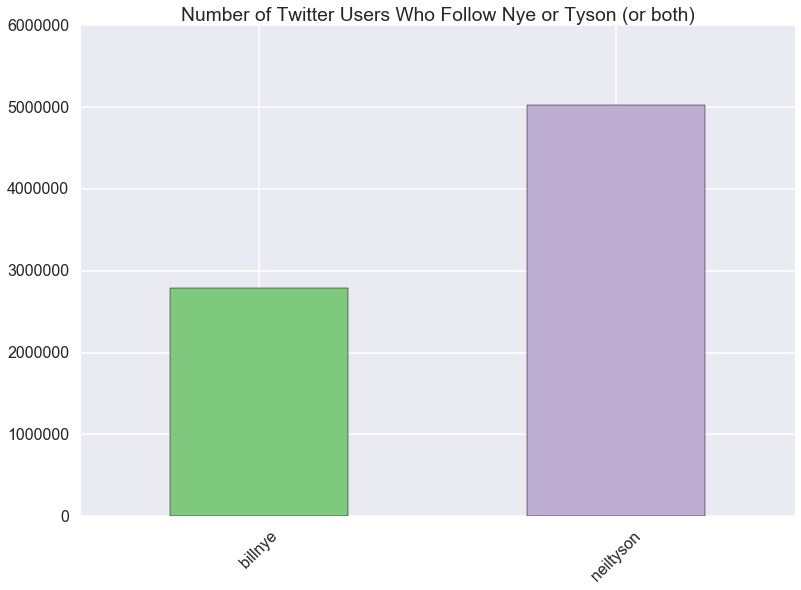

In [9]:
s = pd.Series({k: len(FOLLOWERS[k]) for k in SCIENTISTS})

sns.set_context('poster')
s.plot(kind='bar', color=SCIENTIST_COLORS, rot=45)
plt.title("Number of Twitter Users Who Follow Nye or Tyson (or both)");

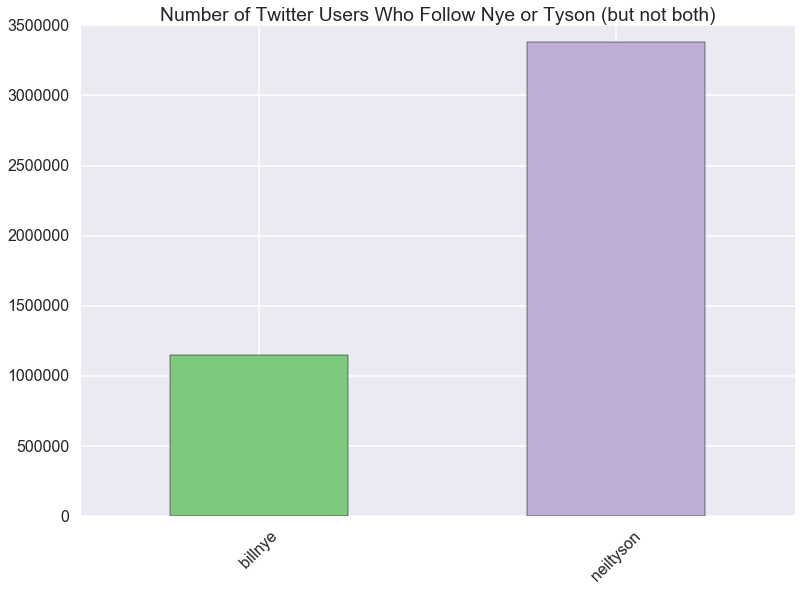

In [10]:
s = pd.Series({k: len(FOLLOWERS[k] - FOLLOWS_BOTH_SCI) for k in SCIENTISTS})

sns.set_context('poster')
s.plot(kind='bar', color=SCIENTIST_COLORS, rot=45)
plt.title("Number of Twitter Users Who Follow Nye or Tyson (but not both)");

## Add Political Dimensions

D    7093898
R    8973598
dtype: int64


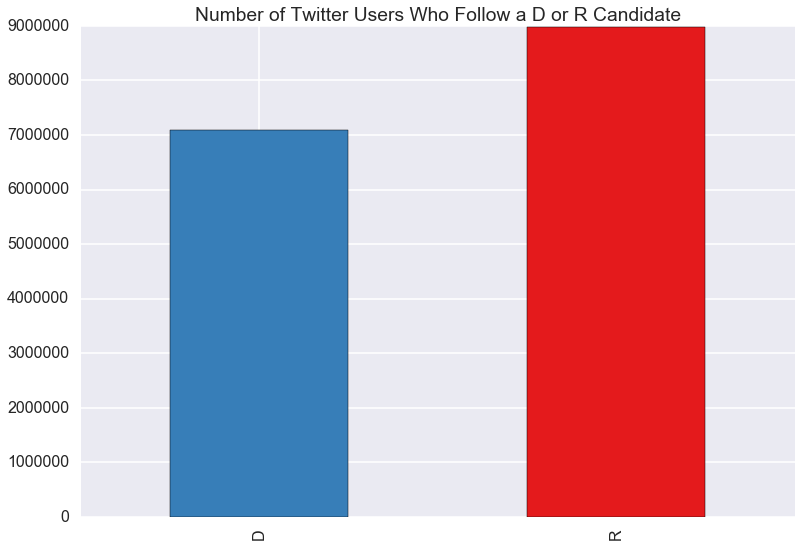

In [11]:
s = pd.Series({k: len(v) for k, v in PARTY_FOLLOWERS.items()})
print(s)

sns.set_context('poster')
s.plot(kind='bar', color=POLITICAL_COLORS)
plt.title("Number of Twitter Users Who Follow a D or R Candidate");

D    5898808
R    7778508
dtype: int64


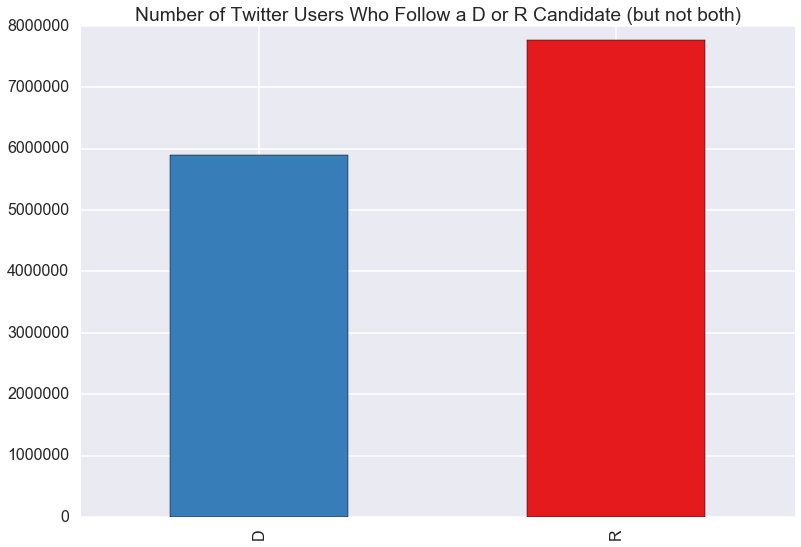

In [12]:
s = pd.Series({k: len(v) for k, v in PARTISON_FOLLOWERS.items()})
print(s)

sns.set_context('poster')
s.plot(kind='bar', color=POLITICAL_COLORS)
plt.title("Number of Twitter Users Who Follow a D or R Candidate (but not both)");

In [13]:
nonuniq_partison = compute_conditionals(PARTY_FOLLOWERS)
nonuniq_partison

,billnye,neiltyson
D,0.082668,0.141361
R,0.034839,0.052292


In [14]:
nonuniq_partison_prime = compute_conditionals(PARTY_FOLLOWERS, ignoring=FOLLOWS_BOTH_SCI)
nonuniq_partison_prime

,billnye,neiltyson
D,0.022507,0.085049
R,0.013644,0.031480


In [15]:
uniq_partison = compute_conditionals(PARTISON_FOLLOWERS)
uniq_partison

,billnye,neiltyson
D,0.076716,0.135104
R,0.022977,0.033862


In [16]:
uniq_partison_prime = compute_conditionals(PARTISON_FOLLOWERS, ignoring=FOLLOWS_BOTH_SCI)
uniq_partison_prime

,billnye,neiltyson
D,0.020839,0.082761
R,0.011174,0.022191


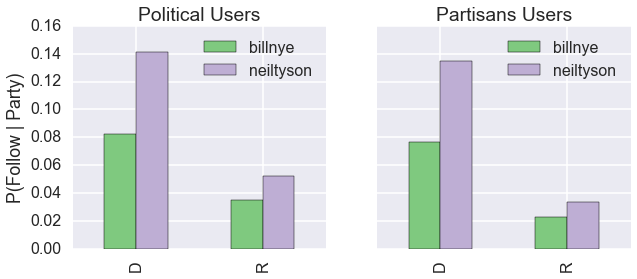

In [17]:
sns.set_context('poster')

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
nonuniq_partison.plot(kind='bar', ax=axes[0], color=SCIENTIST_COLORS)
uniq_partison.plot(kind='bar', ax=axes[1], color=SCIENTIST_COLORS)

axes[0].set_ylabel("P(Follow | Party)")
axes[0].set_title("Political Users")
axes[1].set_title("Partisans Users");

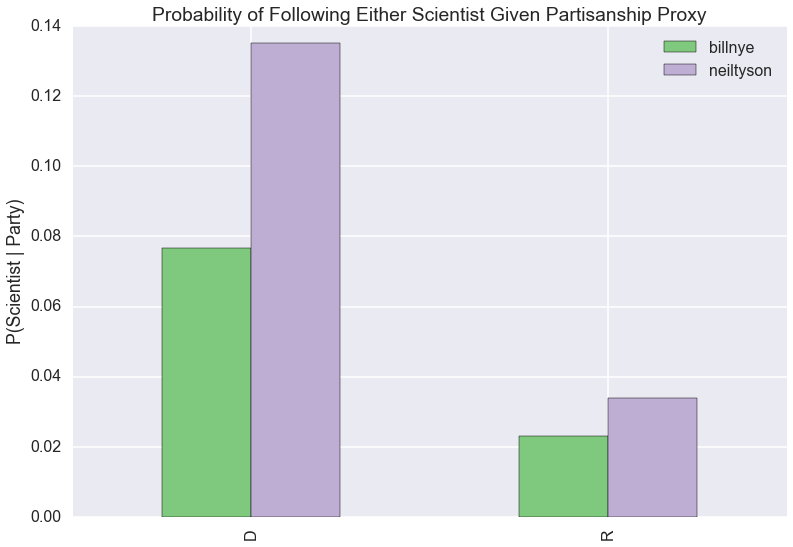

In [18]:
sns.set_context('poster')

uniq_partison.plot(kind='bar', color=SCIENTIST_COLORS)

plt.title("Probability of Following Either Scientist Given Partisanship Proxy")
plt.ylabel("P(Scientist | Party)");

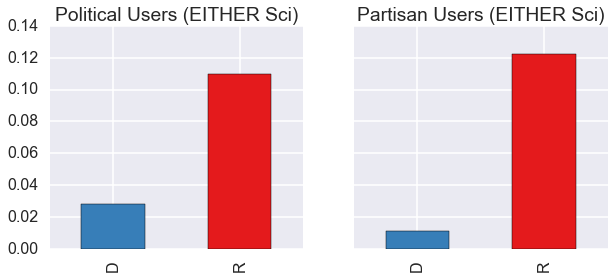

In [19]:
sns.set_context('poster')
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

(nonuniq_partison['billnye'] / 
 nonuniq_partison['neiltyson'] - 
 NYE_TO_TYSON).plot(kind='bar', color=POLITICAL_COLORS, ax=axes[0])

(uniq_partison['billnye'] / 
 uniq_partison['neiltyson'] - 
 NYE_TO_TYSON).plot(kind='bar', color=POLITICAL_COLORS, ax=axes[1])

axes[0].set_title("Political Users (EITHER Sci)")
axes[1].set_title("Partisan Users (EITHER Sci)");

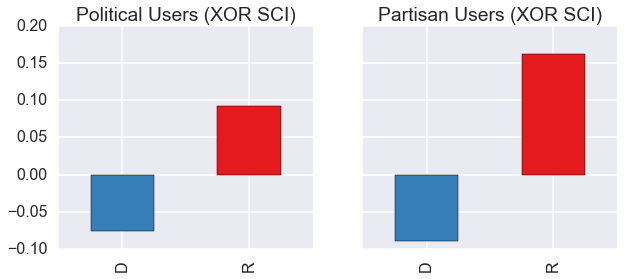

In [20]:
sns.set_context('poster')
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

(nonuniq_partison_prime['billnye'] / 
 nonuniq_partison_prime['neiltyson'] - 
 NYE_TO_TYSON_NONSHARED).plot(kind='bar', color=POLITICAL_COLORS, ax=axes[0])

(uniq_partison_prime['billnye'] / 
 uniq_partison_prime['neiltyson'] - 
 NYE_TO_TYSON_NONSHARED).plot(kind='bar', color=POLITICAL_COLORS, ax=axes[1])

axes[0].set_title("Political Users (XOR SCI)")
axes[1].set_title("Partisan Users (XOR SCI)");

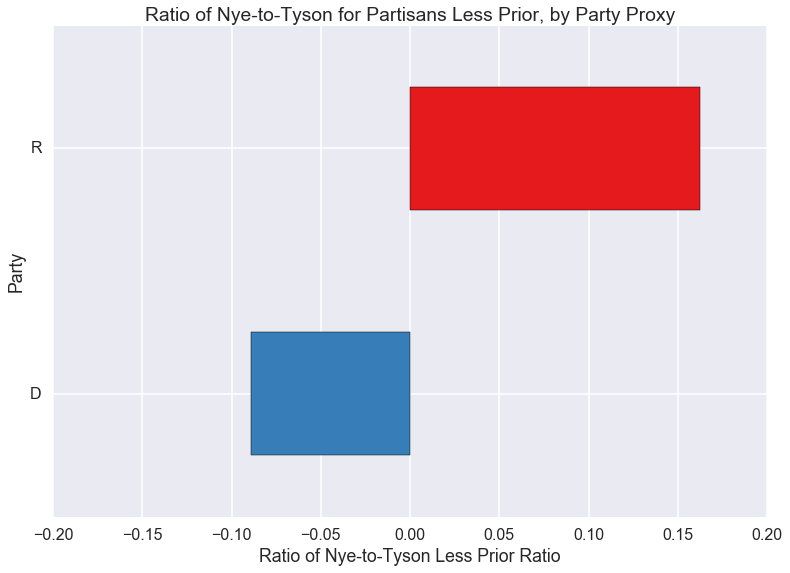

In [21]:
sns.set_context('poster')
(uniq_partison_prime['billnye'] / 
 uniq_partison_prime['neiltyson'] - 
 NYE_TO_TYSON_NONSHARED).plot(kind='barh', 
                              color=['#377eb8', '#e41a1c'])

plt.xlim([-0.2, 0.2])
plt.title("Ratio of Nye-to-Tyson for Partisans Less Prior, by Party Proxy");
plt.ylabel("Party")
plt.xlabel("Ratio of Nye-to-Tyson Less Prior Ratio");

# Candidate Specific 

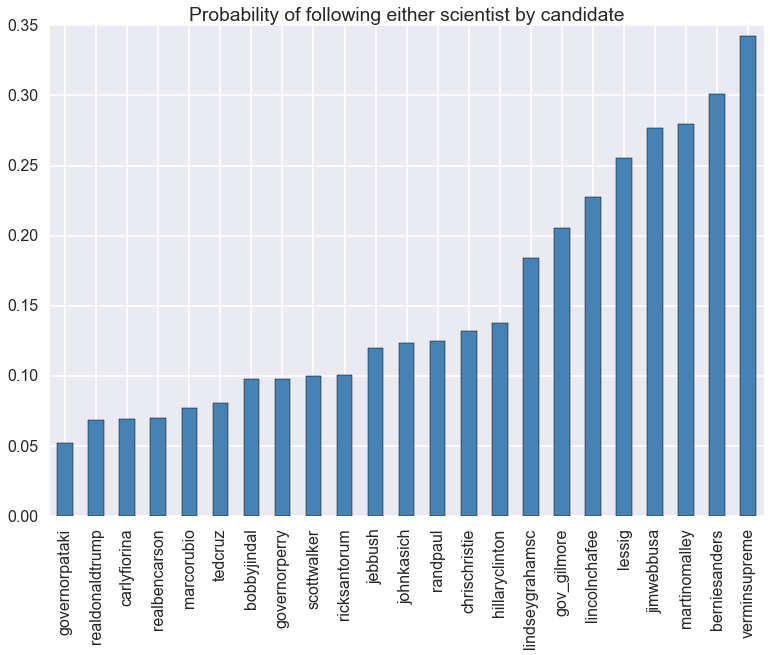

In [22]:
sns.set_context('poster')

follows_either = {}
for k in POLITICIANS:
    follows_either[k] = p_h_given_x(FOLLOWS_EITHER_SCI, FOLLOWERS[k])
pd.Series(follows_either).sort_values().plot(kind='bar', color='steelblue')
plt.title("Probability of following either scientist by candidate");

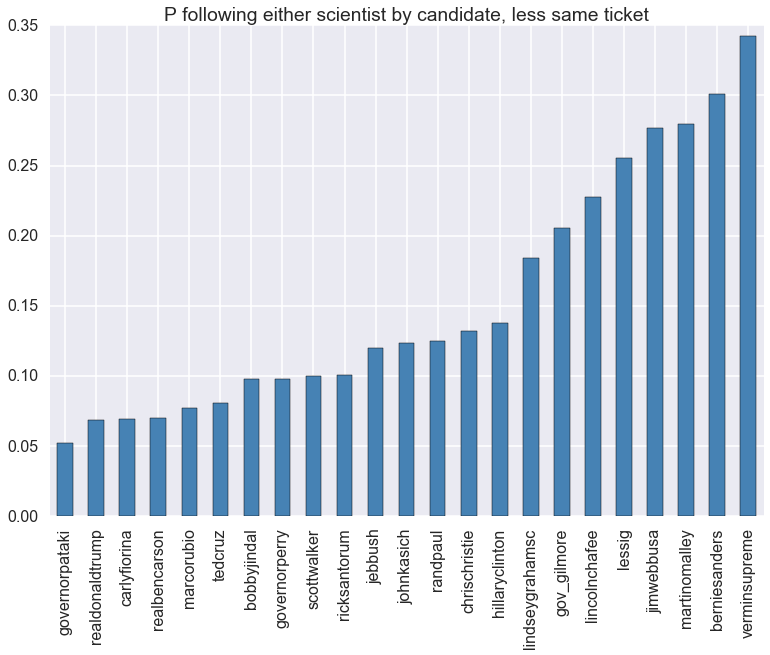

In [23]:
sns.set_context('poster')

follows_either = {}
for party, screen_names in SCREEN_NAMES_BY_PARTY.items():
    for k in screen_names:
        follows_either[k] = p_h_given_x(FOLLOWS_EITHER_SCI, FOLLOWERS[k])

pd.Series(follows_either).sort_values().plot(kind='bar', color='steelblue')
plt.title("P following either scientist by candidate, less same ticket");

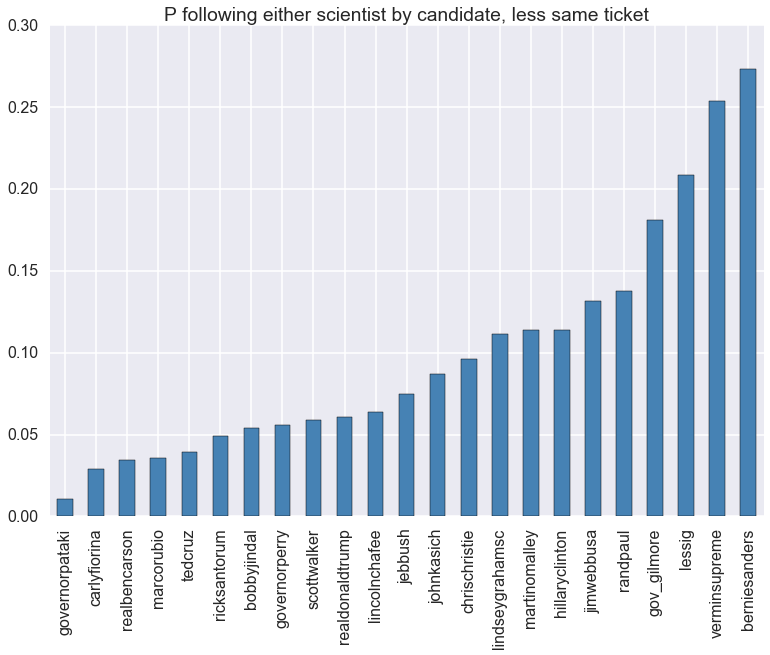

In [24]:
sns.set_context('poster')

follows_either = {}
for party, screen_names in SCREEN_NAMES_BY_PARTY.items():
    for k in screen_names:
        follows_either[k] = p_h_given_x(FOLLOWS_EITHER_SCI, SINGULAR_FOLLOWERS[k])

pd.Series(follows_either).sort_values().plot(kind='bar', color='steelblue')
plt.title("P following either scientist by candidate, less same ticket");

### Confidence Bounds

I don't want to talk about confidence intervals on a medium post. But, I want to make sure things won't reorder much, given statistical bounds. Keeping the minimum number of followers above 10,000 does this cheaply, and keeps things honest.

In [25]:
0.01 - stats.binom(10000, 0.01).ppf(0.01)/10000 

0.0022000000000000006

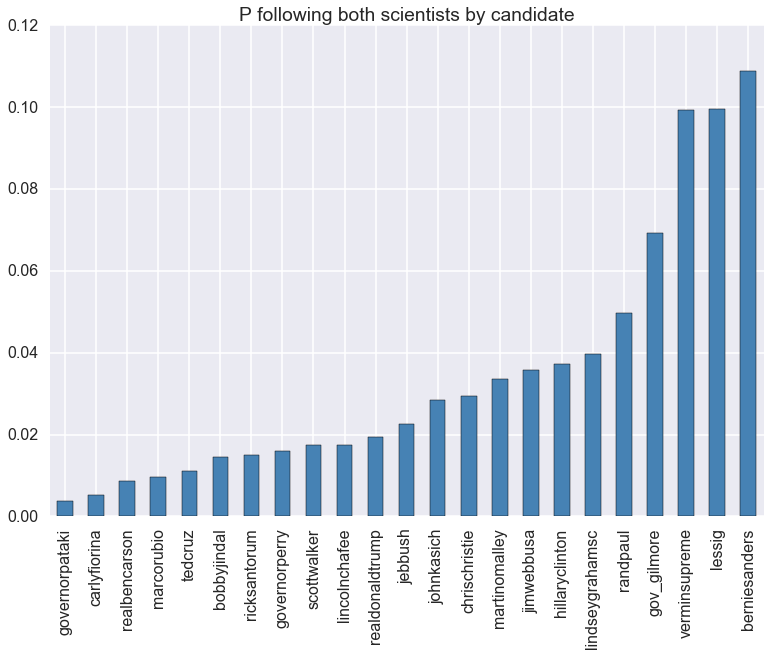

In [26]:
sns.set_context('poster')

follows_either = {}
for party, screen_names in SCREEN_NAMES_BY_PARTY.items():
    for k in screen_names:
        follows_either[k] = p_h_given_x(FOLLOWS_BOTH_SCI, SINGULAR_FOLLOWERS[k])

pd.Series(follows_either).sort_values().plot(kind='bar', color='steelblue');
plt.title("P following both scientists by candidate");

# Gaps

In [27]:
def build_gap_df():
    rows = []
    
    for party, screen_names in SCREEN_NAMES_BY_PARTY.items():
        for k in screen_names:
            x = SINGULAR_FOLLOWERS[k]
            nye = FOLLOWERS['billnye'] - FOLLOWS_BOTH_SCI
            tyson = FOLLOWERS['neiltyson'] - FOLLOWS_BOTH_SCI

            p_1 = p_h_given_x(nye, x)
            p_2 = p_h_given_x(tyson, x)
            theta = p_1 / p_2
            ci = ratio_of_proportions_ci(p_1, p_2, len(x), 100000)
            
            rows.append({'Candidate': k, 
                         'N': len(x),
                         'Theta': theta - NYE_TO_TYSON_NONSHARED,
                         'Lower_Bound': ci[0] - NYE_TO_TYSON_NONSHARED,
                         'Upper_Bound': ci[1] - NYE_TO_TYSON_NONSHARED,
                         'Party': party,
                         'Is_Leader': k in LEADERS})
            
    df = pd.DataFrame(rows).set_index('Candidate')
    df = df.reindex(columns = ['N', 
                               'Lower_Bound', 'Theta', 'Upper_Bound', 
                               'Party', 'Is_Leader'])
    return df

gap_df = build_gap_df()
gap_df

,N,Lower_Bound,Theta,Upper_Bound,Party,Is_Leader
Candidate,,,,,,
governorpataki,50199,-0.119645,-0.049680,0.031624,R,False
johnkasich,62221,-0.017683,0.007325,0.033481,R,False
randpaul,184571,-0.094204,-0.084648,-0.074899,R,False
scottwalker,34024,0.061445,0.110428,0.162741,R,False
tedcruz,94900,0.026710,0.059297,0.093692,R,True
ricksantorum,82264,0.470000,0.531976,0.598519,R,False
governorperry,72302,0.223806,0.268067,0.315014,R,False
bobbyjindal,51052,0.013472,0.050016,0.088680,R,False
jebbush,81698,-0.001056,0.022792,0.047797,R,False


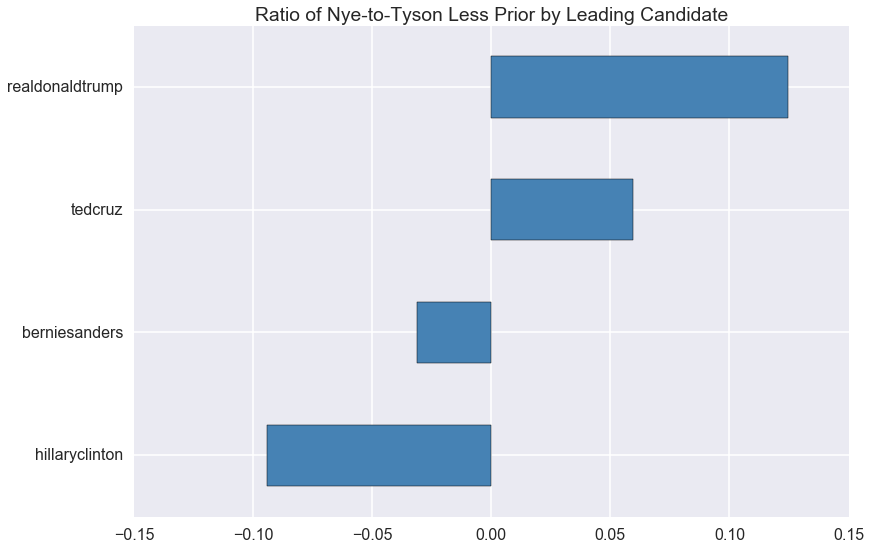

In [28]:
fig, ax = plt.subplots()
sns.set_context('poster')

s = gap_df['Theta'][gap_df['Is_Leader']].sort_values()
s.plot(kind='barh', color='steelblue', ax=ax)
plt.title("Ratio of Nye-to-Tyson Less Prior by Leading Candidate")
plt.ylabel('')
plt.xlim([-0.15, 0.15]);

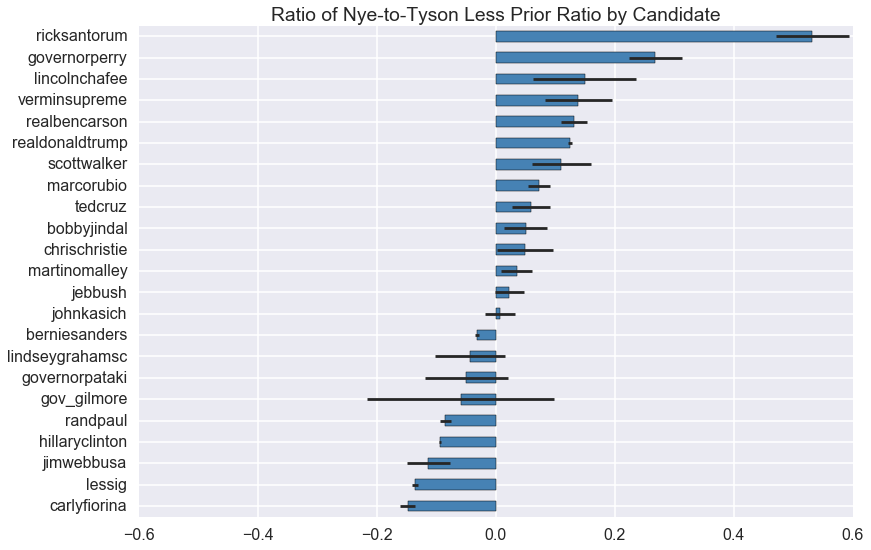

In [29]:
sns.set_context('poster')

s = gap_df['Theta'].sort_values()

raw_err = gap_df[['Lower_Bound', 'Upper_Bound']].subtract(gap_df['Theta'], axis='rows')
err = raw_err.reindex(index=s.index).values.T

s.plot(kind='barh', color='steelblue', xerr=err)
plt.title("Ratio of Nye-to-Tyson Less Prior Ratio by Candidate")
plt.ylabel('')
plt.xlim([-0.6, 0.6]);

The above graph includes all 2016 candidates for POTUS. Two things are unexpected points. 1) Followers of Ben Carson -- the GOP's only black candidate -- follow Nye more than Bill to the same degree as Donald Trump. 2) Carly Fiorina's supporters show the strongest favoritism of Tyson to Nye. The confidence intervals around Carson and Fiorina are wider than for the leading candidates, but they are still substantively significant.

In the case of Carson, homophily as a driver suggests he would have a lot of black followers who then prefer Tyson to Nye. But, this doesn't happen. My guess is that Carson's Twitter Followers are roughly as white as Trump's. This doesn't stretch credulity. Carson's white appeal is well-expressed by Rupert Murdoch: 

(If you don't see the following Tweet, your IPython notebook viewer stripped it for safety.) 

In [30]:
HTML(filename='./murdoch_quote.html')

As [David Lubin said](http://www.usnews.com/news/the-report/articles/2015/10/02/ben-carsons-different-take-on-race), "he's a Republican. He speaks at conservative forums, which are mainly forums for white people. Certainly black Twitter isn't rushing to gush about Ben Carson." 

To empirically test the plausibility of this hypothesis, I gathered the followers of prominent [Black Lives Matter](http://blacklivesmatter.com/) supporters on Twitter. The following shows the candidate-specific follow rates for BLM leaders.

In [39]:
def build_follows_blm(followers_d):
    follows_blm = []
    for k in POLITICIANS:
        n = len(followers_d[k])
        p = p_h_given_x(FOLLOWS_BLM, followers_d[k])
        lb, ub = stats.binom(n, p).ppf([0.025, 0.975]) / n
        row = {'Candidate': k, 
               'P': p, 
               'P_Lower_Raw': lb - p, # "Raw" for Pandas
               'P_Upper_Raw': ub - p} # "Raw" for Pandas
        follows_blm.append(row)
    df = pd.DataFrame(follows_blm).set_index('Candidate')
    return df.sort_values(by='P')

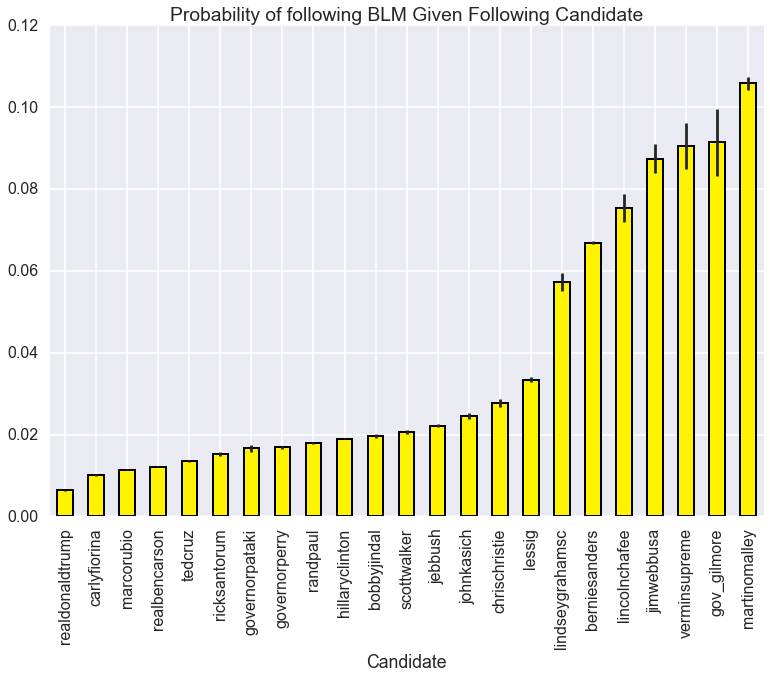

In [51]:
follows_blm = build_follows_blm(FOLLOWERS)

sns.set_context('poster')
follows_blm['P'].plot(kind='bar', 
                      yerr=follows_blm[['P_Lower_Raw', 'P_Upper_Raw']].values.T,
                      color='#FFF300',
                      edgecolor='black',
                      lw=2)
plt.title("Probability of following BLM Given Following Candidate");

And, this graph shows the follow rates for a followers of only the specific candidate: 

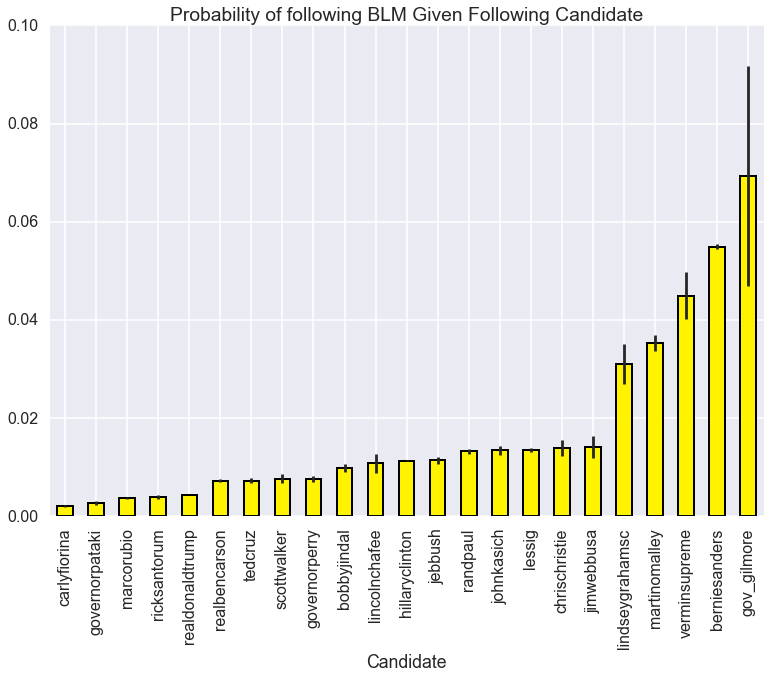

In [52]:
follows_blm = build_follows_blm(SINGULAR_FOLLOWERS)

sns.set_context('poster')
follows_blm['P'].plot(kind='bar', 
                      yerr=follows_blm[['P_Lower_Raw', 'P_Upper_Raw']].values.T,
                      color='#FFF300',
                      edgecolor='black',
                      lw=2)
plt.title("Probability of following BLM Given Following Candidate");

Both show Carson doesn't have much in the way of black support. He does have more than Trump, but -- if he had much black support on twitter -- I assume this rate would be much, much higher.

As for Fiorina, I'm not sure what's going on. She has the lowest set of BLM supporter's of the group. Therefore, I would expect her supporters to favor Nye. I have an idea, unsupported here, by any quantitive analysis: **gender**. 

If you are a woman interested in science on Twitter, you probably are aware of the gender biases against women scientists. Perhaps, cognizant of this bias, you are particularly sensitive to acting correctively. Assuming this were true -- and, assuming Fiorina and Hilary have higher ratios of women followers -- both, would show favoritism towards Tyson. They do. 

But, again, this bit is (currently) unsubstantiated by the collected data. Topics for another notebook.

∎